<a href="https://colab.research.google.com/github/ray-hsiehjy/seizure_recognition/blob/master/Seizure_Recognition_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Source

More details on the data can be found at: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition), the original data source.


In [1]:
# download data
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7456k  100 7456k    0     0  3796k      0  0:00:01  0:00:01 --:--:-- 3794k


## Data information
- The dataset is preprocessed and ready to use
    - Brain EEG recordings from 500 subjects 
    - Each subject was recorded for ~23 seconds at ~178Hz acquisition rate

- Samples are in one-second chuck (178 timesteps)
    - samples = 11500 (23 second * 500 subjects)
    - Tx=178 timesteps at 178Hz (each sample is a 1 second EEG recording)
    - feature = 1 dim vector (EEG readout number, in micro-volt)

- Label y (categorical: 1, 2, 3, 4, 5)
    - shape (sample, 1), last column of the CSV
    - 5 - Eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open
    - 4 - Eyes closed, means when they were recording the EEG signal the patient had their eyes closed
    - 3 - They identify where the region of the tumor was in the brain and recording the EEG activity from healthy area
    - 2 - They recorder the EEG from the area where the tumor was located
- 1 - Recording of seizure activity


Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

## Goal and strategy
- Goal: 
    - Use EEG traces to differentiate states/conditions of subjects
    - Compare performace with and without **"preprocessing"** (temporal convolution)
- Strategy
    - Use a few temporal convolusion layers to extract temporal features (ref, [Amodei et al. 2016](https://arxiv.org/abs/1512.02595), [Ballinger et al. 2018](https://arxiv.org/abs/1802.02511))
    - Followed by bidirectional LSTM layers 
    - Finally piped into dense layers for softmax prediction


## Load packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import CuDNNLSTM, Bidirectional, Dense
# from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K

%matplotlib inline

# Data Preparation

In [3]:
#read in dataset from csv
df = pd.read_csv("/content/data.csv", index_col=0)
df.index.name = "sample id"
df.columns.name ="timepoints"
print(f"There are {len(df)} samples, each with 178 timestamps over 1 second (178Hz sampling rate)")
df.head() # a preview of the dataset

There are 11500 samples, each with 178 timestamps over 1 second (178Hz sampling rate)


timepoints,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
sample id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


## Visualize sample EEG traces

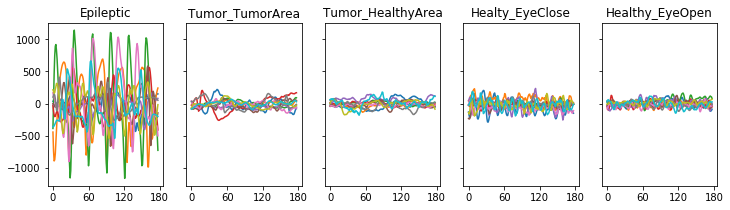

In [4]:
# Show random samples from each group
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(12,3), sharey=True)

num_showing = 10  # number of traces showing from each group
labels = ["Epileptic", "Tumor_TumorArea", "Tumor_HealthyArea", "Healty_EyeClose", "Healthy_EyeOpen"]

for i, ax in enumerate(axes.flat):
    ax.set_title(labels[i])
    ax.set(xticks=np.arange(0,185,60))
    samples = df[df["y"] == (i+1)].sample(num_showing)
    for sample in range(len(samples)):
        ax.plot(np.arange(0,178,1), samples.iloc[sample, :-1])


## Split train_test data

In [5]:
# split pandas dataframe to 90:10 for training and testing
train_X, test_X, train_y, test_y = train_test_split(
    df.iloc[:, :-1], 
    df.iloc[:, -1], 
    test_size=0.1,
    random_state=41
)

# m_train, m_test: number of samples in train/test 
# Tx: number of timestamps
m_train, Tx = train_X.shape 
m_test = test_X.shape[0]

# convert to numpy array. Keras does not take panads dataframe
train_X = train_X.to_numpy().reshape(m_train, Tx, 1)
test_X = test_X.to_numpy().reshape(m_test, Tx, 1)

# convert label to one-hot
output_class = 5 # there are 5 possible predictions
# train_y range from 1-5. Make it from 0-4
train_y_OH = np.eye(output_class)[train_y-1]
test_y_OH = np.eye(output_class)[test_y-1]

print(f"train_X shape: {train_X.shape}")
print(f"train_y_OH shape: {train_y_OH.shape}")

print(f"test_X shape: {test_X.shape}")
print(f"test_y_OH shape: {test_y_OH.shape}")

train_X shape: (10350, 178, 1)
train_y_OH shape: (10350, 5)
test_X shape: (1150, 178, 1)
test_y_OH shape: (1150, 5)


## Check sample balance
- This dataset is preprocessed and balanced, but it is a good practice to check
- Had the sample size not been balanced, we would need to get class weights in a dictionary and feed that into fit() during training

In [6]:
# check training sample balance
balance_df = pd.DataFrame(
    {
    "train": train_y.value_counts(),
    "test": test_y.value_counts()
    }
 )

balance_df.index.name = "condition label"

print("No further balance is needed.")

balance_df

No further balance is needed.


,train,test
condition label,,
1,2093,207
2,2065,235
3,2069,231
4,2074,226
5,2049,251


# Define model and train

## Model structure

#### 3 Conv1D blocks:
- Conv1D --> BatchNorm --> Dropout --> MaxPooling

#### 3 LSTM blocks:
- Bidirectional LSTM --> Dropout
    - some suggest BatchNorm is not suitable for RNN
    - It is unclear whether BatchNorm should be employed with RNN/LSTM-RNN [Cooijmans et al. 2017](https://arxiv.org/abs/1603.09025)

#### Final Dense layer
- Dense --> BatchNorm --> Dropout --> Dense softmax output

In [0]:
def LSTM_model(Tx, name, temporal_conv=True):
    
    '''
    Tx: int, timesteps in the data
    name: name of the model
    temporal_conv: Bool, apply Conv1D before LSTM
    '''
    
    layer_count=0 # for tracking layer names
    X_input = Input(shape=(Tx,1), name=f"input_{layer_count}")
    X = X_input

    if temporal_conv:
        layer_count += 1
        X = Conv1D(128, kernel_size=3, padding="valid", activation="relu", name=f"Conv_{layer_count}")(X)
        X = BatchNormalization(name=f"BN_{layer_count}")(X)
        X = Dropout(0.25, name=f"DP_{layer_count}")(X)
        X = MaxPooling1D(pool_size=2, name=f"MP_{layer_count}")(X)
        
        layer_count += 1
        X = Conv1D(128, kernel_size=5, padding="valid", activation="relu", name=f"Conv_{layer_count}")(X)
        X = BatchNormalization(name=f"BN_{layer_count}")(X)
        X = Dropout(0.25, name=f"DP_{layer_count}")(X)
        X = MaxPooling1D(pool_size=2, name=f"MP_{layer_count}")(X)

        
        layer_count += 1
        X = Conv1D(128, kernel_size=5, padding="valid", activation="relu", name=f"Conv_{layer_count}")(X)
        X = BatchNormalization(name=f"BN_{layer_count}")(X)
        X = Dropout(0.25, name=f"DP_{layer_count}")(X)
        X = MaxPooling1D(pool_size=2, name=f"MP_{layer_count}")(X)

    layer_count += 1
    X = Bidirectional(CuDNNLSTM(128, return_sequences=True, kernel_regularizer="l2"), name=f"BiLSTM_{layer_count}")(X)
    X = Dropout(0.25, name=f"DP_{layer_count}")(X)

    layer_count += 1
    X = Bidirectional(CuDNNLSTM(128, return_sequences=True, kernel_regularizer="l2"), name=f"BiLSTM_{layer_count}")(X)
    X = Dropout(0.25, name=f"DP_{layer_count}")(X)

    layer_count += 1    
    X = Bidirectional(CuDNNLSTM(128, kernel_regularizer="l2"), name=f"BiLSTM_{layer_count}")(X)
    X = Dropout(0.25, name=f"DP_{layer_count}")(X)
    
    layer_count += 1
    X = Dense(128, activation="relu", name=f"Dense_{layer_count}")(X)
    X = BatchNormalization(name=f"BN_{layer_count}")(X)
    X = Dropout(0.25, name=f"DP_{layer_count}")(X)

    output = Dense(5, activation="softmax", name="output")(X)

    model = Model(inputs=X_input, outputs=output, name=name)

    return model


## Create model graph and train

In [8]:
input_shape = train_X.shape[1]

model_ntc = LSTM_model(Tx=input_shape, name="model_ntc", temporal_conv=False)
# model_ntc.summary()

model_tc = LSTM_model(Tx=input_shape, name="model_tc", temporal_conv=True)
# model_tc.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
histories = {}

for model in [model_ntc, model_tc]:

    opt=Adam(lr=1e-3)

    lr_reduction = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2, 
        patience=10, 
        verbose=1,
        min_delta=1e-4,
        cooldown=0,
        min_lr=1e-6
    )

    early_stop = EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=25, 
        verbose=1,
    )

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    print(f"Start training {model.name}")

    histories[model.name] = model.fit(
        train_X, 
        train_y_OH,
        validation_split=0.1, 
        batch_size=128, 
        epochs=150,
        callbacks=[lr_reduction, early_stop],
        verbose=0
    )

Start training model_ntc

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 00068: early stopping
Start training model_tc

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 00098: early stopping


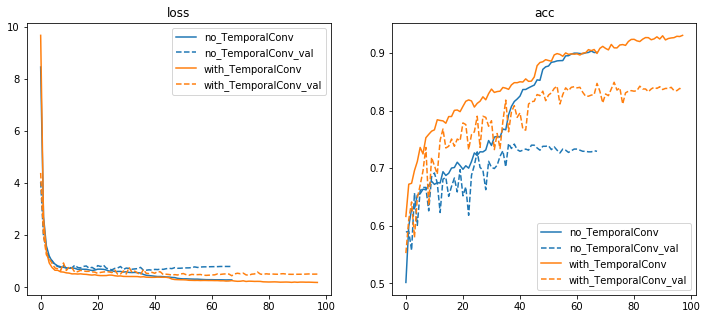

In [13]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for m, ax in zip(["loss", "acc"], axes.flat):
    ax.plot(histories["model_ntc"].history[m], label="no_TemporalConv", color="C0")
    ax.plot(histories["model_ntc"].history[f"val_{m}"], label="no_TemporalConv_val", color="C0", linestyle="--")
    ax.plot(histories["model_tc"].history[m], label="with_TemporalConv", color="C1")
    ax.plot(histories["model_tc"].history[f"val_{m}"], label="with_TemporalConv_val", color="C1", linestyle="--")
    ax.set(title=m)
    ax.legend()
# axes[0].set(ylim=(0,10))
# axes[1].set(ylim=(0.4,0.9))


# Performance

In [0]:
pred_OH = model_tc.predict(test_X) # pred_OH shape (num_sample, num_class) values are prob
pred = np.argmax(pred_OH, axis=-1) # get prediction class 0-4

                   precision    recall  f1-score   support

        Epileptic       1.00      0.95      0.98       207
  Tumor_TumorArea       0.80      0.70      0.75       235
Tumor_HealthyArea       0.73      0.78      0.75       231
  Healty_EyeClose       0.93      0.88      0.90       226
  Healthy_EyeOpen       0.81      0.92      0.86       251

         accuracy                           0.84      1150
        macro avg       0.85      0.85      0.85      1150
     weighted avg       0.85      0.84      0.84      1150



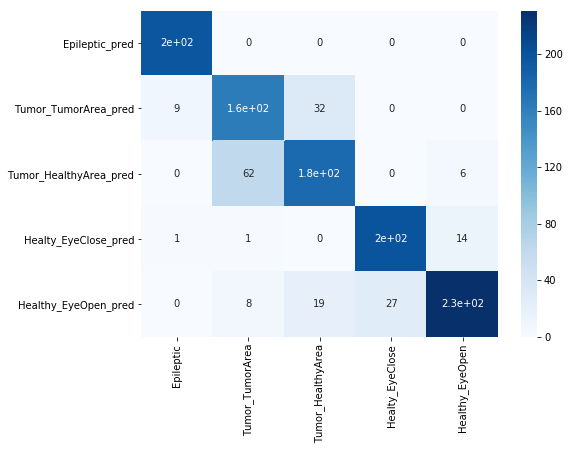

In [12]:
# test_y range from 1-5, covnert to 0-4
groups = ["Epileptic", "Tumor_TumorArea", "Tumor_HealthyArea", "Healty_EyeClose", "Healthy_EyeOpen"]
confusion = confusion_matrix(test_y-1, pred)

report = classification_report(test_y-1, pred, target_names=groups)

print(report)

confusion = pd.DataFrame(confusion.T, index=[f"{g}_pred" for g in groups], columns=groups)
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot=True, annot_kws={"size":10}, cmap="Blues")

# Conclusion

- Adding temporal conv layers before LSTM helps neural network learns faster and better. 
- In general, model_tc is performing well in differentiating major groups: healthy, tumor, epileptic; however, it is having a bit hard time telling minor groups: Tumor_TumorArea vs Tumor_HealthyArea and Healthy_EyeClose vs Healthy_EyeOpen.
- Interestingly, 19 recordings from Tumor_healthyArea were classified as healthy_EyeOpen, suggesting the local neuronal activities are not affected by tumor mass. 
